## 1 Tracking simple objects in videos

### 1.1 Particle Filters

In this exercise, you will implement a simple object tracker based on the Particle Filter. Some test video sequences can be downloaded from the link below :
https://drive.google.com/file/d/1k4RoERodDDEmLUzy_EhYPUaMlfzkRKVP/view?usp=drive_link

A motivating example is given in sequence seq23.avi that shows the tracking result of a (standard) Particle Filter on a real sequence.
The tracked area (object) is initialized by the user and its shape is assumed to be fixed. We will consider here a rectangle, parameterized by the position of its center.The hidden state is thus represented by a 2-dimensional vector.

Transition function.
We are interested in the scenario where no apriori information on the movement of the tracked object is available.The transition model is therefore given by:

Xk = Xk-1 + Vk

where Vk N(0, Sigma) is a Gaussian white noise, Sigma is a diagonal matrix.

**Likelihood function.** <br>
We calculate a normalized color histogram (Nb bins) associated with the tracked area and those associated with the particles in order to approximate the likelihood function. More precisely, at a time instant k, each particle xik i=1, ..., N will define an area on the image. A histogram is then calculated from this area.The likelihood function is constructed by comparing the obtained histogram with the reference histogram (the one associated with the tracked area). Here we assume that the histogram associated with the tracked area is time invariant.The distance between two color histograms h and h' is defined as:

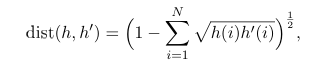

où h(i) et h′(i) sont les i-èmes bins des histogrammes h et h′ , respectivement. La fonction de vraisemblance est alors approximée par :

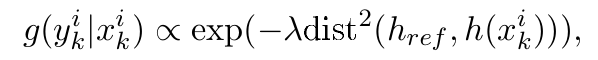

where h ref is the reference histogram, h(x i k) is the histogram associated with particle x i k, and C is a constant. Details of the tracking algorithm are given below:"

Step 1 : Initialize the tracked area by determining the position of center of rectangle and its size.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

## Step 1
Initialize the tracked area by determining the position of center of rectangle
and its size

In [ ]:
cap = cv2.VideoCapture('escrime-4-3.avi')
ret, image = cap.read()

num_of_particles = 200
state_init = np.array([320, 240, 0, 0])  # initial state [x_center, y_center, x_velocity, y_velocity]

# bounding box's height and width.
half_height = 18
half_width = 18

## Step 2
Calculate the reference histogram href associated with the initial tracked area.

In [ ]:
def compute_norm_hist(image, state, half_height, half_width):
    """
    Compute histogram based on the RGB values of the image in the ROI defined by the state.
    Args:
        image (np.ndarray): matrix representing image with the object to track in it
        state (np.ndarray): vector of the state of the tracked object

    Returns:
        vector of the normalized histogram of the colors in the (ROI = region of interest) of the image based on the state
    """
    bins = 4096
    # get the top-left and bottom-right corner of the object bounding boxL
    x_min = max(np.round(state[0] - half_width).astype(int), 0)
    x_max = min(np.round(state[0] + half_width).astype(int), image.shape[1])
    y_min = max(np.round(state[1] - half_height).astype(int), 0)
    y_max = min(np.round(state[1] + half_height).astype(int), image.shape[0])

    roi = image[y_min:y_max+1, x_min:x_max+1]
    roi_reduced = roi // 32  # to reduce complexity
    # build vector to represent the combinations of RGB as a single value
    roi_indexing = (roi_reduced[..., 0] + roi_reduced[..., 1] * 16 + roi_reduced[..., 2] * 16 ** 2).flatten()
    hist, _ = np.histogram(roi_indexing, bins, range=(0, bins))
    
    # Ensure normalization of the histogram
    href = hist / np.sum(hist) if np.sum(hist) > 0 else np.ones(bins) / bins  # uniform distribution if all zeros
    return href


In [ ]:
q = compute_norm_hist(image, state_init, half_height, half_width)

In [ ]:
# Parameters
half_width = 50
half_height = 50
frame_interval = 10  # Interval to skip frames
num_frames = 20      # Number of frames to analyze
frame_count = 0
histograms = []

# Loop to read frames and compute histograms
while len(histograms) < num_frames:
    ret, frame = cap.read()
    
    if not ret:
        print("End of video or read error.")
        break

    if frame_count % frame_interval == 0:
        hist_norm = compute_norm_hist(frame, state_init, half_height, half_width)
        histograms.append(hist_norm)
    
    frame_count += 1

# Release resources
cap.release()

# Plot histograms
plt.figure(figsize=(10, 6))

for i, hist in enumerate(histograms):
    plt.plot(np.arange(4096), hist, label=f"Frame {i * frame_interval}")

plt.title(f"Normalized Histograms for {num_frames} Frames taken 1 out of {frame_interval}")
plt.xlabel("Color Combination (RGB Index)")
plt.ylabel("Probability")
plt.legend()
plt.show()


In [ ]:
# Parameters
half_width = 50
half_height = 50
frame_interval = 10  # Interval to skip frames
num_frames = 20      # Number of frames to analyze
frame_count = 0
histograms = []

# Loop to read frames and compute histograms
while len(histograms) < num_frames:
    ret, frame = cap.read()
    
    if not ret:
        print("End of video or read error.")
        break

    if frame_count % frame_interval == 0:
        hist_norm = compute_norm_hist(frame, state_init, half_height, half_width)
        histograms.append(hist_norm)
    
    frame_count += 1

# Release resources
cap.release()

# Plot histograms
plt.figure(figsize=(10, 6))

for i, hist in enumerate(histograms):
    plt.plot(np.arange(4096), hist, label=f"Frame {i * frame_interval}")
plt.xlim(0, 100)

plt.title(f"Normalized Histograms for {num_frames} Frames taken 1 out of {frame_interval}")
plt.xlabel("Color Combination (RGB Index)")
plt.ylabel("Probability")
plt.legend()
plt.show()


## Step 3 
Initialize a set of N particles by generating random positions around the center
of tracked area. Initial particle weights are set to w_0_i

In [ ]:
def sample_particle(particles_states, weights):
    """
    Systematic resampling algorithm for particle filter.
    
    Args:
        particles_states (np.ndarray): matrix which its columns are the states
        weights (np.ndarray): weights of each state

    Returns:
        (np.ndarray): matrix of resampled states according to their weights
    """
    N = weights.size

    # First, normalize weights 
    normalized_weights = weights / np.sum(weights)
    # Calculate the commulative sum to get the interval
    cumulative_sum = np.cumsum(normalized_weights)
    
    # Generate a single random starting point in [0, 1/N]
    start = np.random.uniform(0, 1/N)
    # Define the regularly spaced points
    positions = (start + np.arange(N) / N) % 1 # to be within [0,1]
    
    # Find the indices of the particles to be resampled
    indices = np.searchsorted(cumulative_sum, positions)
    
    # Resample particles which indices are selected from the interval condition
    resampled_particles = particles_states[:, indices]
    return resampled_particles

weights = np.ones(num_of_particles)
s_new = np.tile(state_init, (num_of_particles, 1)).T
print(np.shape(s_new))
s_sampled = sample_particle(s_new, weights)
print(np.shape(s_sampled))

## Step 4
It includes 3 main steps in the Particle Filter. At every time instant k, a set
of N particles with associated weights x_i,w_i is maintained to track the
object. Note that particle weights are normalized 

### Prediction : 

**Transition function**

The goal of this step is to predict the position of the tracked object using the transition model in Eq. 1.

In [ ]:
def predict_particles(particles_states):
    """
    Args:
        particles_states (np.ndarray): matrix of states. The rows are the properties of the state and the columns are the particles

    Returns:
        (np.ndarray): new predicted particles
    """
    # the dynamic we use assume that:
    # x_k = x + v_x_(k-1) 
    # y_k = y + v_y_(k-1)
    # v_x_k = v_x_(k-1) 
    # v_y_k = v_y_(k-1) 
    dynamics = np.array(
        [[1 ,0, 1, 0],
         [0, 1, 0, 1],
         [0, 0, 1, 0],
         [0, 0, 0, 1]]
    )
    predicted_states = dynamics @ particles_states + np.random.normal(loc=0, scale=1, size=particles_states.shape)
    return predicted_states

### Correction :

**Likelihood function**

This step is used to correct the predicted position obtained from the previous step using the observation from the current image. The likelihood function is constructed from Eqs. 2 and 3. The particle weights are then updated

In [ ]:
def likelihood(p, q):
    """
    Args:
        p, q (np.ndarray): normalized histogram
    """
    dist = 1-np.sum(np.sqrt(p * q)) 
    return np.exp(-10 * dist) 

### Test

In [ ]:

def draw_bounding_box(image, states, weights, half_height, half_width, with_max=True):
    """
    Args:
        image (np.ndarray): the image to draw recangle on
        states (np.ndarray): the sampling states
        weights (np.ndarray): the weight of each state
        with_max (bool): True to draw a rectangle according to the state with the highest weight

    Returns:
        (np.ndarray): image with rectangle drawn on for the tracked object
    """
    mean_box = np.average(states, axis=1, weights=weights)
    x_c_mean, y_c_mean = np.round(mean_box[:2]).astype(int)
    image_with_boxes = image.copy()
    cv2.rectangle(image_with_boxes, (x_c_mean - half_width, y_c_mean - half_height),
                                     (x_c_mean + half_width, y_c_mean + half_height), (255, 0, 255), 1)
    return image_with_boxes

def draw_particles(image, states, weights):
    """
    Args:
        image (np.ndarray): the image to draw particles on
        states (np.ndarray): the sampling states
        weights (np.ndarray): the weight of each state

    Returns:
        (np.ndarray): image with particles drawn on
    """
    image_with_particles = image.copy()
    for s, w in zip(states.T, weights):
        x, y = np.round(s[:2]).astype(int)
        cv2.circle(image_with_particles, (x, y), int(round(30 * w)), (255, 0, 255), thickness=-1)
    return image_with_particles

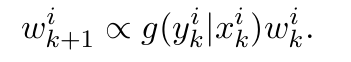

- Resampling : <br>
This step alleviates a common problem of Particle Filter referred to as sample degeneracy. It replicates particles with high weights and remove those with low weights. The most commonly used resampling algorithms are :

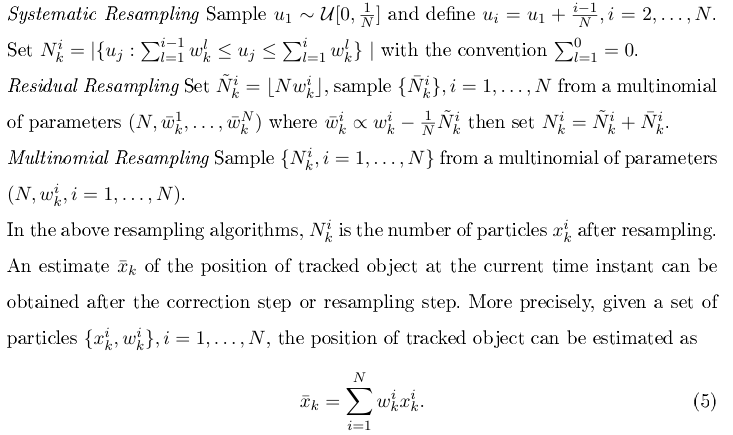

### 1.2 Practical Work

- Implement the Particle Filter algorithm described in the previous section to track a moving object in a video sequence.
- Test your tracker with di erent settings of parameters : (transition model), (likelihood model), Nb (color histogram), N (number of particles). Implementation of the systematic resampling algorithm is mandatory. The other two resampling algorithms are optional (you'll get bonus points if you implement them).
- Test your tracker with a reduced number of video frames (e.g., remove one frame for every two consecutive frames). Compare the accuracy of your tracker in the two cases (tracking the object in the original video and in the video with a reduced number of frames). Which components (parameters, algorithms) you should change in order for the tracker to work?
- The size of object is now assumed to be varied during tracking. Adapt your tracker to this scenario. What do you observe in terms of tracking accuracy? Why?
- Propose some other methods for constructing the likelihood model. Compare the performance (accuracy, computation time) of your tracker when using di erent likelihood models.
- In order to made a thorough study on the performance of your tracker, you are asked to test it on your own videos. For simplicity, you might create a square/rectangle/circle/triangle that moves in a video. Di erent levels of di culties can be added to investigate the robustness of your tracker :
- Vary the moving spead of objects.
- Objects lled with more colors.
- Clustered background videos instead of clean background ones.
- Videos with multiple moving objects. What do you observe when some objects are
 occluded by some others? Propose a solution to deal with the problem.

By creating your own videos, you'll be able to calculate the tracking errors by comparing the positions of tracked object estimated by your tracker with the groundtruth positions. <br>
Plot the tracker accuracy over time for di erent cases considered above.

In [ ]:
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fps = 20

size = (frame_width, frame_height)
result = cv2.VideoWriter('test_video/10.avi',
                         cv2.VideoWriter_fourcc(*'MJPG'),
                         fps, size)

while True:
    ret, image = cap.read()
    if not ret:
        break

    # sample new particles according to the weights
    s_sampled = sample_particle(s_new, weights)
    # predict new particles states according to the previous states
    s_new = predict_particles(s_sampled)
    
    # compute histogram and weigths
    for jj, s in enumerate(s_new.T):
        p = compute_norm_hist(image, s, half_height, half_width)
        weights[jj] = likelihood(p, q)

    s_new_new = sample_particle(s_new,weights) # resampling

    # draw bounding box over the tracked object
    image_with_boxes = draw_bounding_box(image, s_new_new, weights, half_height, half_width, with_max=True)
    normalized_weights = weights / np.sum(weights)
    image_with_particles = draw_particles(image_with_boxes, s_sampled, normalized_weights)
    
    result.write(image_with_particles)

cap.release()
result.release()

## 2 Tracking complex objects in videos
### 2.1 Particle Filters for high-dimensional problems

In this exercise, we will implement a Particle Filter algorithm for tracking an articulated object (e.g., human body, human hand) in a video. Some demo videos resulted from tracking human poses with such an algorithm are provided with this handout.<br>
For simplicity, we will work with simulation videos like the one given in the previous exercise. The target object consists of a center part (square) connected with 4 hands. Each object's hand consists of some rectangles linked together. Different objects have different numbers of rectangles in their hands. We note that once the algorithm for tracking such objects has been implemented, only a few modifications are needed to make it work as shown in the demo videos.<br>

Since the target object has multiple parts to be tracked, we can no longer represent the hidden state by a 2-dimensional vector as in the previous exercise. Instead, we must use a high dimensional vector to represent the hidden state. In theory, the number of particles required to track the object grows exponentially with the dimension of hidden state. We are thus facing the problem referred to as the curse of dimensionality in Particle Filter methods. In order to alleviate this problem, we will use an advanced version of Particle Filter algorithm whose steps are given below :

1. Initialize a set of particles to track the object. You might use the same method in the previous exercise.
2. Track the object's center part using a Particle Filter.
3. Track the object's hands sequentially using a Particle Filter. Note that when a specific part of a hand is tracked, the transition model is only applied to the part in question. Also, particle weights should be evaluated based only on the observation related to the target part. In practice, the order for tracking the object's hands might have an important impact on the tracking accuracy. For simplicity, you can assume a xed order when tracking the object's hand.

You might use the same transition and likelihood models as well as the resampling algorithm
that work well for you in the previous exercise.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

cap = cv2.VideoCapture('escrime-4-3.avi')

ret, image = cap.read()

if not ret:
    print("Erreur lors de la lecture de la vidéo")
else:
    num_of_particles = 50
    state_init = np.array([320, 240, 0, 0]) 

    bounding_boxes = [
        (320, 240, 18*2, 18*2),

        (355, 240, 14*2, 6*2), 
        (385, 240, 14 * 2, 6 * 2),   
        (415, 240, 14 * 2, 6 * 2), 

        (285, 240, 14 * 2, 6 * 2),   
        (255, 240, 14 * 2, 6 * 2),   
        (225, 240, 14 * 2, 6 * 2),   

        (320, 275, 6*2, 14*2),
        (320, 305, 6*2, 14*2),
        (320, 335, 6*2, 14*2),

        (320, 205, 6*2, 14*2),
        (320, 175, 6*2, 14*2),
        (320, 145, 6*2, 14*2)

    ]

    for (x, y, w, h) in bounding_boxes:
        top_left = (x - w // 2, y - h // 2)
        bottom_right = (x + w // 2, y + h // 2)
        cv2.rectangle(image, top_left, bottom_right, (255, 0, 255), 2) 

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(16, 12))
    plt.imshow(image_rgb)
    plt.axis() 
    plt.grid()
    plt.show()

cap.release()


### 2.3 Practical Work
- Implement the Particle Filter algorithm described in the previous section to track a moving object in a video sequence.

- Test your tracker with different settings of parameters : (transition model), 

1.   List item
2.   List item

(likelihood model), Nb (color histogram), N (number of particles). Implementation of the systematic resampling algorithm is mandatory. The other two resampling algorithms are optional (you'll get bonus points if you implement them).

- Test your tracker with a reduced number of video frames (e.g., remove one frame for every two consecutive frames). Compare the accuracy of your tracker in the two cases (tracking the object in the original video and in the video with a reduced number of frames). Which components (parameters, algorithms) you should change in order for the tracker to work?

- Propose some other methods for constructing the likelihood model. Compare the performance (accuracy, computation time) of your tracker when using di erent likelihood models.

- In order to made a thorough study on the performance of your tracker, you are asked to test it on your own videos. For simplicity, you might create a square/rectangle/circle/triangle that moves in a video. Di erent levels of di culties can be added to investigate the ro
bustness of your tracker:
  - Vary the moving spead of objects.
  - Objects lled with more colors.
  - Clustered background videos instead of clean background ones.
  - Videos with multiple moving objects. What do you observe when some objects are occluded by some others? Propose a solution to deal with the problem.

By creating your own videos, you'll be able to calculate the tracking errors by comparing the positions of tracked object estimated by your tracker with the groundtruth positions.<br>
Plot the tracker accuracy over time for di erent cases considered above.

In [ ]:
import cv2
import numpy as np

cap = cv2.VideoCapture('escrime-4-3.avi')
ret, image = cap.read()

num_of_particles = 60

state_init_list = [
    np.array([320, 240, 0, 0]),
    np.array([355, 240, 0, 0]),
    np.array([385, 240, 0, 0]),
    np.array([415, 240, 0, 0]),
    np.array([285, 240, 0, 0]),
    np.array([255, 240, 0, 0]),
    np.array([225, 240, 0, 0]),
    np.array([320, 275, 0, 0]),
    np.array([320, 305, 0, 0]),
    np.array([320, 335, 0, 0]),
    np.array([320, 205, 0, 0]),
    np.array([320, 175, 0, 0]),
    np.array([320, 145, 0, 0])
]

half_width_list = [18, 15, 15, 15, 15, 15, 15, 6, 6, 6, 6, 6, 6]
half_height_list = [18, 6, 6, 6, 6, 6, 6, 15, 15, 15, 15, 15, 15]

frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fps = 20
size = (frame_width, frame_height)
result = cv2.VideoWriter('part_2_all_boxes_3.avi', cv2.VideoWriter_fourcc(*'MJPG'), fps, size)

q_list = []
weights_list = []
s_new_list = []
s_new_new_list = [None] * len(state_init_list)


for i, init_state in enumerate(state_init_list):
    half_height = half_height_list[i]
    half_width = half_width_list[i]
    
    q = compute_norm_hist(image, init_state, half_height, half_width)
    q_list.append(q)
    weights_list.append(np.ones(num_of_particles))
    s_new_list.append(np.tile(init_state, (num_of_particles, 1)).T)

while True:
    ret, image = cap.read()
    if not ret:
        break

    for i in range(len(state_init_list)):
        half_height = half_height_list[i]
        half_width = half_width_list[i]

        s_sampled = sample_particle(s_new_list[i], weights_list[i])
        s_new_list[i] = predict_particles(s_sampled)
        
        for jj, s in enumerate(s_new_list[i].T):
            p = compute_norm_hist(image, s, half_height, half_width)
            weights_list[i][jj] = likelihood(p, q_list[i])
        
        s_new_new_list[i] = sample_particle(s_new_list[i], weights_list[i])

        image = draw_bounding_box(image, s_new_new_list[i], weights_list[i], half_height, half_width, with_max=True)

    for i in range(len(state_init_list)):
        normalized_weights = weights_list[i] / np.sum(weights_list[i])
        image = draw_particles(image, s_new_list[i], normalized_weights)

    result.write(image)

cap.release()
result.release()
